In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:

data_path = Path('../Data/Raw/Mendeley_data/100_Batches_IndPenSim_v3.csv')
df_raw = pd.read_csv(data_path)

print(f"Raw data shape: {df_raw.shape}")


Raw data shape: (113935, 2239)


In [3]:

variable_raman_data = np.split(df_raw, [df_raw.columns.get_loc("2400")], axis=1)
df = variable_raman_data[0].copy()
raman_spectra = variable_raman_data[1].copy()

if '2-PAT control(PAT_ref:PAT ref)' in df.columns:
    df = df.rename(columns={
        '2-PAT control(PAT_ref:PAT ref)': 'Batch reference(Batch_ref:Batch ref)',
        'Batch reference(Batch_ref:Batch ref)': '2-PAT control(PAT_ref:PAT ref)'
    })

batch_col = 'Batch reference(Batch_ref:Batch ref)'
fault_col = 'Fault reference(Fault_ref:Fault ref)'

print(f"\nProcess data shape: {df.shape}")
print(f"Unique batches: {df[batch_col].nunique()}")


Process data shape: (113935, 39)
Unique batches: 100


In [4]:

critical_cols = ['Time (h)', 'Penicillin concentration(P:g/L)', batch_col, fault_col, 'Batch ID']
df = df.dropna(subset=critical_cols).reset_index(drop=True)

print(f"After cleaning: {df.shape}")
print(f"\nFault distribution:\n{df[fault_col].value_counts()}")

After cleaning: (113935, 39)

Fault distribution:
Fault reference(Fault_ref:Fault ref)
0.0    112679
1.0      1256
Name: count, dtype: int64


In [5]:
cols_to_drop = [
    batch_col,  
    fault_col,  
    'Fault flag',  
    'Time (h)', 
    'Batch ID' 
]

operator_cols = [col for col in df.columns if 'operator' in col.lower()]
cols_to_drop.extend(operator_cols)

feature_cols = [col for col in df.columns if col not in cols_to_drop]
print(f"\nNumber of process features: {len(feature_cols)}")




Number of process features: 33


In [6]:

print(f"\nMissing values per feature:")
missing_counts = df[feature_cols].isnull().sum()
print(missing_counts[missing_counts > 0])

df[feature_cols] = df[feature_cols].fillna(method='ffill').fillna(method='bfill').fillna(0)


Missing values per feature:
PAA concentration offline(PAA_offline:PAA (g L^{-1}))      111873
NH_3 concentration off-line(NH3_offline:NH3 (g L^{-1}))    111873
Offline Penicillin concentration(P_offline:P(g L^{-1}))    111873
Offline Biomass concentratio(X_offline:X(g L^{-1}))        111873
Viscosity(Viscosity_offline:centPoise)                     111873
dtype: int64


In [7]:

print("\nCreating batch-level dataset")

batch_data = []
for batch_id in sorted(df[batch_col].unique()):
    batch_df = df[df[batch_col] == batch_id].copy()
    
    if len(batch_df) == 0:
        continue
    
    fault_label = batch_df[fault_col].max()  
    
    
    row = {'Batch_ID': int(batch_id), fault_col: int(fault_label)}
    
    for feat in feature_cols:
        values = batch_df[feat].values
        row[f'{feat}_mean'] = np.mean(values)
        row[f'{feat}_std'] = np.std(values)
        row[f'{feat}_min'] = np.min(values)
        row[f'{feat}_max'] = np.max(values)
        row[f'{feat}_trend'] = values[-1] - values[0] 
    
    batch_data.append(row)

batch_agg_df = pd.DataFrame(batch_data)
print(f"Batch aggregated data shape: {batch_agg_df.shape}")
print(f"Fault distribution:\n{batch_agg_df[fault_col].value_counts()}")



Creating batch-level dataset
Batch aggregated data shape: (100, 167)
Fault distribution:
Fault reference(Fault_ref:Fault ref)
0    90
1    10
Name: count, dtype: int64


In [8]:

scaler = StandardScaler()
feature_cols_agg = [col for col in batch_agg_df.columns  
                     if col not in ['Batch_ID', fault_col]]

X_agg = batch_agg_df[feature_cols_agg].copy() 
X_agg_scaled = scaler.fit_transform(X_agg)
X_agg_scaled = pd.DataFrame(X_agg_scaled, columns=feature_cols_agg)

y = batch_agg_df[fault_col].values 

print(f"\nAggregated feature matrix shape: {X_agg_scaled.shape}")
print(f"Label distribution (IMBALANCED): {np.bincount(y)}")


Aggregated feature matrix shape: (100, 165)
Label distribution (IMBALANCED): [90 10]


In [9]:

output_dir = Path('../Data/Processed')
output_dir.mkdir(exist_ok=True)

batch_agg_df.to_csv(output_dir / 'batch_data_agg.csv', index=False)
pd.DataFrame(X_agg_scaled).to_csv(output_dir / 'X_aggregated.csv', index=False)
pd.DataFrame(y).to_csv(output_dir / 'y_labels.csv', index=False)

with open(output_dir / 'scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print(f"\nPreprocessed data saved to {output_dir}")



Preprocessed data saved to ..\Data\Processed


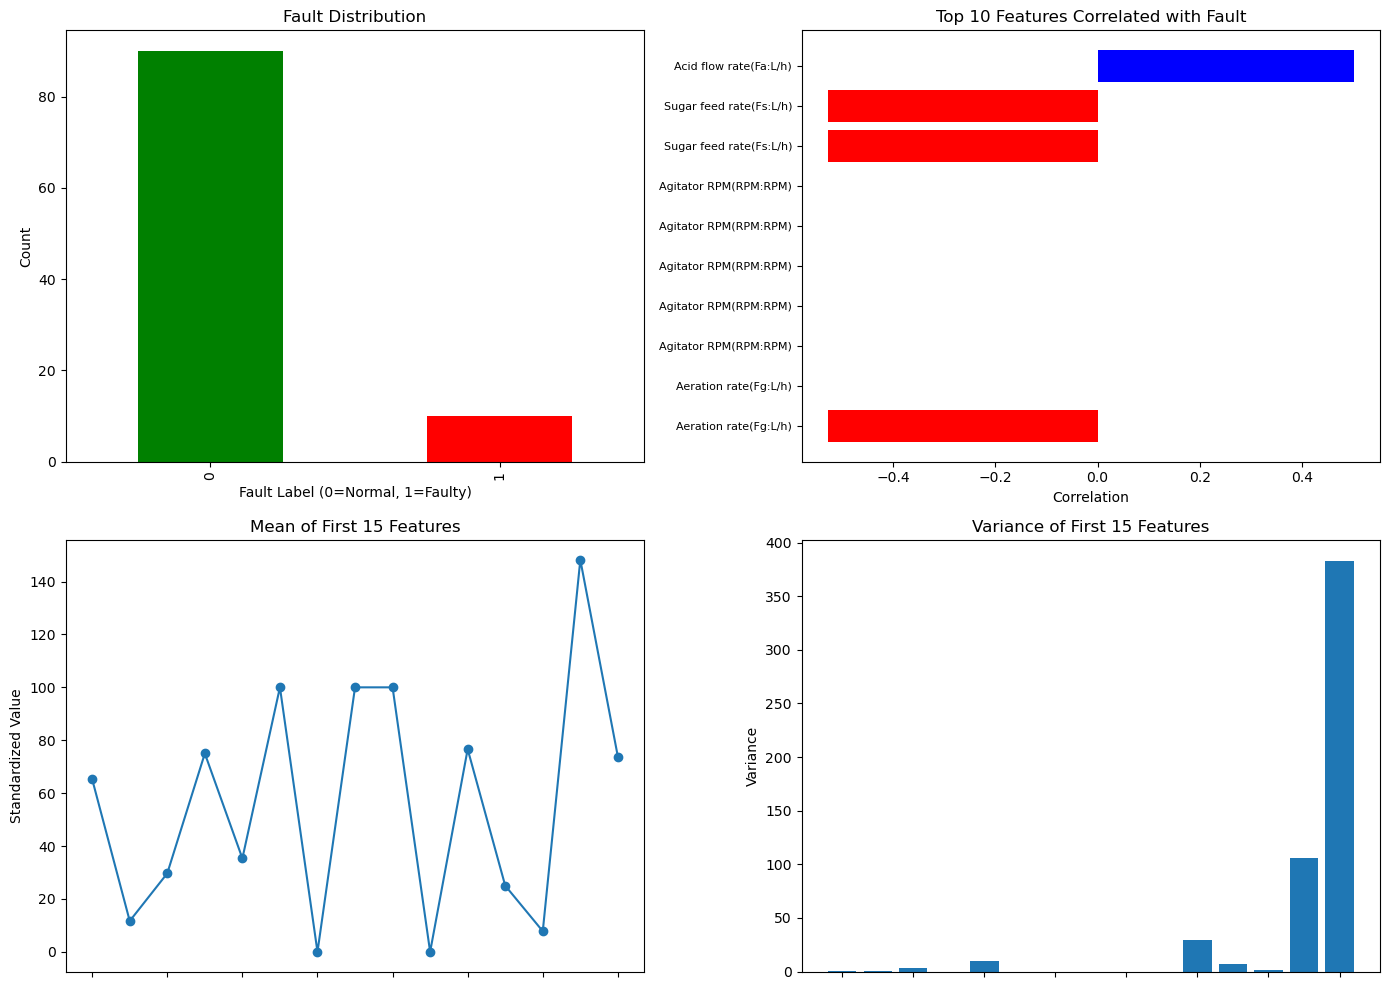

In [10]:

fig, axes = plt.subplots(2, 2, figsize=(14, 10))


ax = axes[0, 0]
batch_agg_df[fault_col].value_counts().plot(kind='bar', ax=ax, color=['green', 'red'])
ax.set_title('Fault Distribution')
ax.set_xlabel('Fault Label (0=Normal, 1=Faulty)')
ax.set_ylabel('Count')

ax = axes[0, 1]
correlations = []
for feat in feature_cols_agg[:20]:  
    corr = batch_agg_df[feat].corr(batch_agg_df[fault_col])
    correlations.append((feat.split('_')[0], corr))
correlations.sort(key=lambda x: abs(x[1]), reverse=True)
feat_names, corr_vals = zip(*correlations[:10])
ax.barh(range(len(feat_names)), corr_vals, color=['red' if x < 0 else 'blue' for x in corr_vals])
ax.set_yticks(range(len(feat_names)))
ax.set_yticklabels(feat_names, fontsize=8)
ax.set_title('Top 10 Features Correlated with Fault')
ax.set_xlabel('Correlation')

ax = axes[1, 0]
feature_means = X_agg[feature_cols_agg[:15]].mean()
ax.plot(range(len(feature_means)), feature_means.values, marker='o')
ax.set_title('Mean of First 15 Features')
ax.set_ylabel('Standardized Value')
ax.set_xticklabels([], fontsize=8)


ax = axes[1, 1]
feature_vars = X_agg[feature_cols_agg[:15]].var()
ax.bar(range(len(feature_vars)), feature_vars.values)
ax.set_title('Variance of First 15 Features')
ax.set_ylabel('Variance')
ax.set_xticklabels([], fontsize=8)

plt.tight_layout()
plt.show()
plt.close()